# Data science take-home assignment

### Overview
The objective of this assignment is to create a model that predicts the likelihood that a patient will have a hospital admission in the next 180 days. This assignment gives the candidate the opportunity to demonstrate their data wrangling, feature engineering and model building capabilities.

It is strongly recommended that the output of this assignment be a well structured jupyter notebook. Pandas and Sklearn are recommended, but not required. If you want to prototype in Matlab, R or Excel, feel free to do so. If that is the case, a transformed jupyter notebook or source code plus write-up can help us post-process the results.

**The minimum model performance metrics that must be reported are the model’s ROC AUC and precision-recall curve AUC.**

### Data Dictionary
All patient data has been de-identified and event dates have been replaced with days until prediction.

TO DO:
- predict likelihood that pt will have hospital admission in next 180 days
- 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### patient data ###
prediction_obj = pd.read_csv('patient_data/prediction_objective.csv')
demographics = pd.read_csv('patient_data/demographics.csv')
medications = pd.read_csv('patient_data/medications.csv')
claims = pd.read_csv('patient_data/claims.csv')
diagnosis = pd.read_csv('patient_data/diagnosis.csv')

### reference data ###
atc_crosswalk = pd.read_csv('reference_data/atc_crosswalk.csv')
ccs_crosswalk = pd.read_csv('reference_data/ccs_crosswalk.csv')

## Data Exploration

In [3]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

In [4]:
# "prediction_obj" data
print(prediction_obj.columns)
print('')
prediction_obj.info()
print('')
print('Number of patients:', len(prediction_obj))
print(f'Prevalence:', calc_prevalence(prediction_obj['HAS_ADMISSION'].values))
print('Number of patients with admission:', len(prediction_obj[prediction_obj['HAS_ADMISSION']==1]))

Index(['PATIENT_ID', 'HAS_ADMISSION'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   PATIENT_ID     100000 non-null  int64
 1   HAS_ADMISSION  100000 non-null  int64
dtypes: int64(2)
memory usage: 1.5 MB

Number of patients: 100000
Prevalence: 0.0459
Number of patients with admission: 4590


**"prediction_obj" dataset**
- There are no non-values (NaNs) in the dataset. Not dropping any rows.
- Around 4.6% of the population has admission. This represents a class imbalance, which may be a problem when feeding into a predictive model (because model will be biased towards the majority class). 

Index(['PATIENT_ID', 'SEX', 'AGE'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PATIENT_ID  100000 non-null  int64 
 1   SEX         100000 non-null  object
 2   AGE         100000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


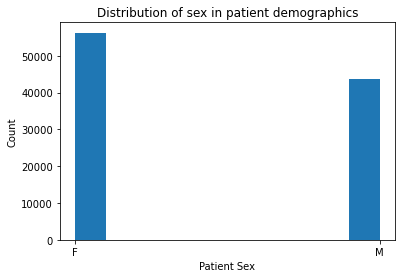

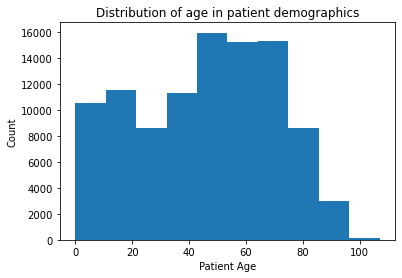

In [5]:
# "demographics" data
print(demographics.columns)
print('')
demographics.info()

plt.hist(demographics["SEX"])
plt.title("Distribution of sex in patient demographics")
plt.xlabel("Patient Sex")
plt.ylabel("Count")
plt.show()

plt.hist(demographics["AGE"])
plt.title("Distribution of age in patient demographics")
plt.xlabel("Patient Age")
plt.ylabel("Count")
plt.show()

**"demographics" dataset**
- There are no non-values (NaNs) in the dataset. Not dropping any rows. 
- quick glance at SEX column, seems like Female:Male ratio is skewed towards Females. However, not huge imbalance. May need to re-balance later before feeding into model.
- quick glance at AGE column, seems like distribution is somewhat normal, but right skewed (more patients <20y.o. vs. >80y.o.)

Index(['PATIENT_ID', 'DATESTART', 'MEDICATION_NAME', 'NDC_CODE', 'DOSAGE',
       'DISPENSING_QUANTITY', 'DAYS_SUPPLY', 'ROUTE', 'STRENGTH'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2198090 entries, 0 to 2198089
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   PATIENT_ID           int64  
 1   DATESTART            int64  
 2   MEDICATION_NAME      object 
 3   NDC_CODE             int64  
 4   DOSAGE               float64
 5   DISPENSING_QUANTITY  float64
 6   DAYS_SUPPLY          int64  
 7   ROUTE                object 
 8   STRENGTH             float64
dtypes: float64(3), int64(4), object(2)
memory usage: 150.9+ MB

 MEDICATION_NAME column null values: 94
 DOSAGE column null values: 1781918
 DISPENSING_QUANTITY column null values: 26
 ROUTE column null values: 643897
 STRENGTH column null values: 1781918


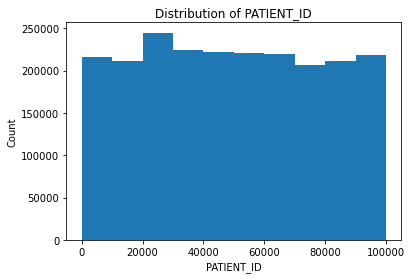

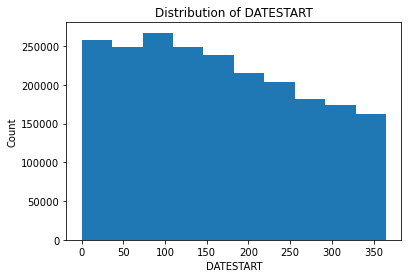

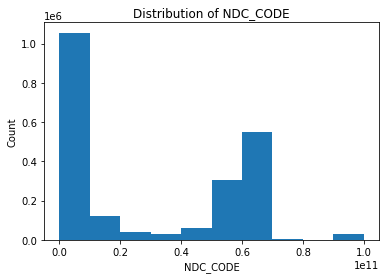

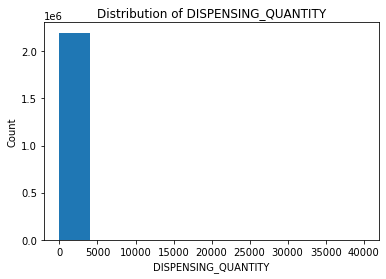

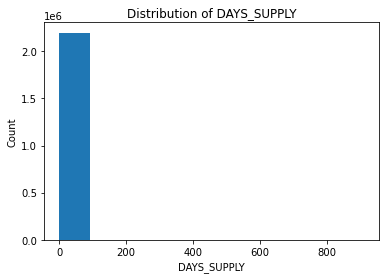

In [6]:
# "medications" data
# DATESTART = The prescription’s start date relative to the date of prediction. 
# For example 5 would be 5 days until the prediction date.

print(medications.columns)
print('')
medications.info()
print('')

for col in medications.columns:
    col_null_sum = medications[col].isnull().sum()
    if col_null_sum != 0:
        print(f'', col, 'column null values:', col_null_sum)

new_medications_cols = [x for x in medications.columns 
                        if x not in("DOSAGE", "STRENGTH", "ROUTE")]
for col in new_medications_cols:
    if col not in ("MEDICATION_NAME"):
        plt.hist(medications[col])
        plt.title('Distribution of '+col)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()

Text(0.5, 1.0, '< 1500')

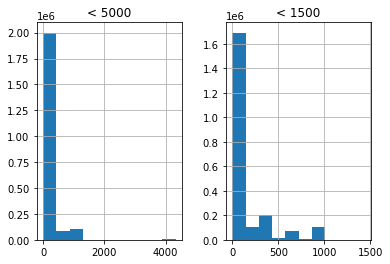

In [7]:
# histogram of "DISPENSING_QUANTITY" < 5000 
med_1 = medications[medications["DISPENSING_QUANTITY"]<5000]
# histogram of "DISPENSING_QUANTITY" < 1500
med_2 = medications[medications["DISPENSING_QUANTITY"]<1500]

fig, axes = plt.subplots(1,2)
med_1.hist("DISPENSING_QUANTITY", ax=axes[0])
med_2.hist("DISPENSING_QUANTITY", ax=axes[1])
axes[0].set_title('< 5000')
axes[1].set_title('< 1500')

In [8]:
medications[medications["DISPENSING_QUANTITY"]>5000].head()

,PATIENT_ID,DATESTART,MEDICATION_NAME,NDC_CODE,DOSAGE,DISPENSING_QUANTITY,DAYS_SUPPLY,ROUTE,STRENGTH
10965,77345,153,Dextrose-NaCl 5-0.9 % SOLN,264761000,NaN,10000.0,5,IV,NaN
13547,77345,164,Dextrose-NaCl 5-0.9 % SOLN,264761000,NaN,12000.0,6,IV,NaN
30628,45085,24,PEG 3350 ELECTROLYTE SOLN,62175044601,NaN,8000.0,1,NOT SPEC,NaN
33038,55005,95,ZEMAIRA INJ 1000MG,53720102,1000.0,11400.0,28,IV,1000.0
36092,19577,32,GAVILYTE-G SOL,43386009019,NaN,8000.0,1,NaN,NaN


In [9]:
medications[medications["DAYS_SUPPLY"]>100].head()

,PATIENT_ID,DATESTART,MEDICATION_NAME,NDC_CODE,DOSAGE,DISPENSING_QUANTITY,DAYS_SUPPLY,ROUTE,STRENGTH
10995,50708,28,SIMVASTATIN 20 MG TABLET,16729000517,NaN,180.0,180,NOT SPEC,NaN
11282,42378,167,PROAIR HFA 90 MCG INHALER,59310057922,NaN,8.0,235,INHALATI,NaN
20698,83193,36,ACCU-CHEK AVIVA PLUS TEST STRP,65702040810,NaN,100.0,120,MISCELL.,NaN
37020,56831,272,PROLIA 60 MG/ML SYRINGE,55513071001,NaN,1000.0,180,SUB-Q,NaN
39788,56831,272,PROLIA 60 MG/ML SYRINGE,55513071001,NaN,1000.0,180,SUB-Q,NaN


**"medications" dataset**
- There are 2,198,090 rows while this dataset only has 100,000 patients -- meaning that patients may have multiple different prescribed medications. 
- DOSAGE and STRENGTH columns have over 1 million null values, and ROUTE column has over 600,000 null values. Due to large null values which represent data incompleteness, will dropping these columns from analysis. Large data incompleteness may introduce noise in ML model.
- NCD_CODE histogram not normally distributed but ok because represents national drug code, which is categorical.
- DISPENSING_QUANTITY and DAYS_SUPPLY histograms super right skewed, looks like there may be outlier(s). The outliers don't look too abnormal -- **ask whether the outliers may be input errors**, but include them in analysis for now. 

In [10]:
claims

,PATIENT_ID,CLAIM_ID,ADMISSION_DATE,DISCHARGE_DATE,DRG_CODE,REVENUE_CODE,CPT_CODE,PLACE_OF_SERVICE
0,50392,A42024972,299,299.0,NaN,636.0,J2405,23
1,31326,A43478232,87,86.0,NaN,762.0,G0378,22
2,38128,A42946783,42,42.0,NaN,305.0,85730,23
3,7372,A43664805,230,228.0,NaN,402.0,76937,23
4,59228,A152404886,79,78.0,NaN,305.0,85025,23
...,...,...,...,...,...,...,...,...
3175887,32716,B57705706,143,143.0,NaN,NaN,A0999,41
3175888,86965,B154112151,161,161.0,NaN,NaN,A0427,41
3175889,87169,B153906049,145,145.0,NaN,NaN,A4253,12
3175890,39563,B124389815,297,297.0,NaN,NaN,77080,12


In [11]:
# "claims" data
# ADMISSION_DATE = Start date of the claim relative to the prediction date. 
# For example 5 would be 5 days until the prediction date.

print(claims.columns)
print('')
claims.info()
print('')

for col in claims.columns:
    col_null_sum = claims[col].isnull().sum()
    if col_null_sum != 0:
        print(f'', col, 'column null values:', col_null_sum)

Index(['PATIENT_ID', 'CLAIM_ID', 'ADMISSION_DATE', 'DISCHARGE_DATE',
       'DRG_CODE', 'REVENUE_CODE', 'CPT_CODE', 'PLACE_OF_SERVICE'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3175892 entries, 0 to 3175891
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   PATIENT_ID        int64  
 1   CLAIM_ID          object 
 2   ADMISSION_DATE    int64  
 3   DISCHARGE_DATE    float64
 4   DRG_CODE          float64
 5   REVENUE_CODE      float64
 6   CPT_CODE          object 
 7   PLACE_OF_SERVICE  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 193.8+ MB

 DISCHARGE_DATE column null values: 470071
 DRG_CODE column null values: 3059566
 REVENUE_CODE column null values: 2689603
 CPT_CODE column null values: 166380


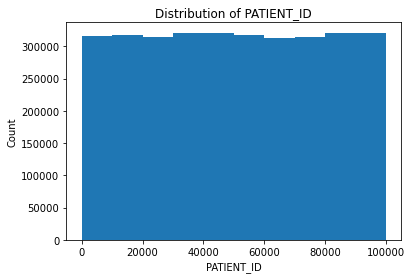

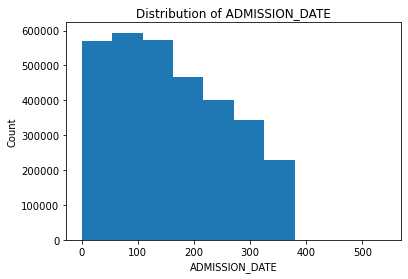

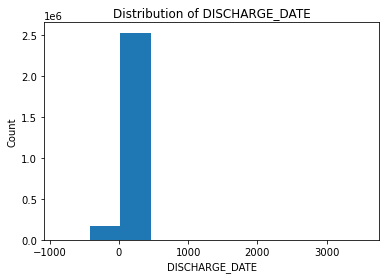

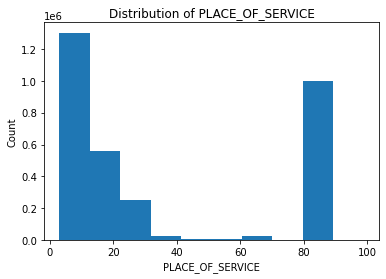

In [12]:
new_claims_cols = [x for x in claims.columns if x not in("DRG_CODE", "REVENUE_CODE")]
for col in new_claims_cols:
    if col not in ("CLAIM_ID", "CPT_CODE"):
        plt.hist(claims[col])
        plt.title('Distribution of '+col)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()

**"claims" dataset**
- There are 3,175,892 rows.
- DRG_CODE has over 3 million null values, and REVENUE_CODE has over 2.6 million. These columns will be dropped due to data incompleteness. DISCHARGE_DATE and CPT_CODE have less than 500,000 null values, so will be kept in the analysis. 
- CLAIM_ID drop from analysis because each row is a new claim ID ?
- CPT_CODE no histogram because codes are a mix of letters + numbers ... use bar chart to visualize data? 
- negative DISCHARGE_DATE?? 
- may need to create a new column that calculated difference between ADMISSION_DATE and DISCHARGE_DATE

In [13]:
claims[claims["DISCHARGE_DATE"]<0]

,PATIENT_ID,CLAIM_ID,ADMISSION_DATE,DISCHARGE_DATE,DRG_CODE,REVENUE_CODE,CPT_CODE,PLACE_OF_SERVICE
371805,44285,B105786740,9,-21.0,NaN,NaN,90960,65
372037,40698,B132227960,4,-11.0,NaN,420.0,97110,22
372205,20339,B154398679,10,-20.0,NaN,NaN,90966,65
372744,13397,B72407544,7,-14.0,NaN,420.0,97530,22
373113,53621,B130297988,5,-25.0,NaN,NaN,90960,65
...,...,...,...,...,...,...,...,...
3170445,2490,B156138784,4,-11.0,NaN,851.0,90945,65
3170598,32136,B50281457,102,-19.0,NaN,NaN,99213,11
3171911,73868,B71391101,5,-20.0,NaN,421.0,97116,22
3173085,13487,B83488275,20,-10.0,NaN,270.0,A4657,65


Index(['CLAIM_ID', 'PRIORITY', 'CODE_TYPE', 'CODE', 'CODE_DESCRIPTION'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2809365 entries, 0 to 2809364
Data columns (total 5 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   CLAIM_ID          object
 1   PRIORITY          int64 
 2   CODE_TYPE         object
 3   CODE              object
 4   CODE_DESCRIPTION  object
dtypes: int64(1), object(4)
memory usage: 107.2+ MB

 CODE_DESCRIPTION column null values: 77


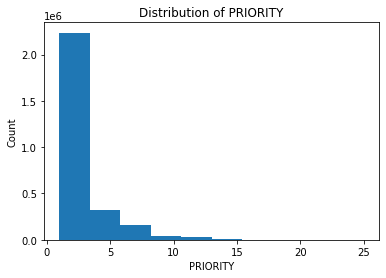

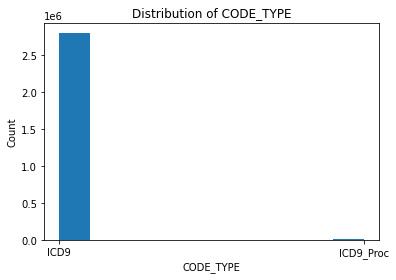

In [14]:
# "diagnosis" data

print(diagnosis.columns)
print('')
diagnosis.info()
print('')

for col in diagnosis.columns:
    col_null_sum = diagnosis[col].isnull().sum()
    if col_null_sum != 0:
        print(f'', col, 'column null values:', col_null_sum)

new_diagnosis_cols = [x for x in diagnosis.columns if x not in("CLAIM_ID", "CODE_DESCRIPTION", "CODE")]
for col in new_diagnosis_cols:
    plt.hist(diagnosis[col])
    plt.title('Distribution of '+col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

In [15]:
diagnosis

,CLAIM_ID,PRIORITY,CODE_TYPE,CODE,CODE_DESCRIPTION
0,A106686371,4,ICD9,250.00,DIABETES MELLITUS WITHOUT MENTION OF COMPLICAT...
1,A112336349,6,ICD9,V45.81,POSTSURGICAL AORTOCORONARY BYPASS STATUS
2,A12060184251289,16,ICD9,274.00,"Gouty arthropathy, unspecified"
3,A106226016,5,ICD9,338.29,OTHER CHRONIC PAIN
4,A100457749,1,ICD9,786.09,OTHER DYSPNEA AND RESPIRATORY ABNORMALITY
...,...,...,...,...,...
2809360,BV12061940063054,1,ICD9,V76.2,SCREENING FOR MALIGNANT NEOPLASM OF THE CERVIX
2809361,BV12061940063054,3,ICD9,402.10,BENIGN HYPERTENSIVE HEART DISEASE WITHOUT CONG...
2809362,BV12061940063054,2,ICD9,401.1,"ESSENTIAL HYPERTENSION, BENIGN"
2809363,BV12061940063054,5,ICD9,493.00,"EXTRINSIC ASTHMA, UNSPECIFIED"


**"diagnosis" dataset**
- CLAIM_ID most likely unique for each row, and CODE_DESCRIPTION irrelevant to predicting hospital admission. Drop both columns from analysis.
- can use CODE_DESCRIPTION later on if using NLP (eg., BERT) to parse through the descriptions to find patterns
- need bar chart for CODE ?
- may want to use CODE and not CODE_TYPE, because CODE more unique whereas there are only 2 ICD CODE_TYPE in this dataset

In [16]:
atc_crosswalk # Classification system for grouping medications.

,NDC,ATC,ATC_LABEL
0,000015356041,V03AF01,mesna
1,000015356141,V03AF01,mesna
2,000015356241,V03AF01,mesna
3,000015356302,V03AF01,mesna
4,000015356303,V03AF01,mesna
...,...,...,...
1844778,00517102025,H01BA01,vasopressin (argipressin)
1844779,54569391601,H01BA01,vasopressin (argipressin)
1844780,54868574000,H01BA01,vasopressin (argipressin)
1844781,61553095348,H01BA01,vasopressin (argipressin)


In [17]:
ccs_crosswalk # Classification system for grouping diagnosis and procedure codes.

,diag_code,diag_code_type,ccs_code,ccs_code_type,label
0,010_01,ICD9,1,CCS_DIAGNOSIS,Tuberculosis
1,010_02,ICD9,1,CCS_DIAGNOSIS,Tuberculosis
2,010_03,ICD9,1,CCS_DIAGNOSIS,Tuberculosis
3,010_04,ICD9,1,CCS_DIAGNOSIS,Tuberculosis
4,010_05,ICD9,1,CCS_DIAGNOSIS,Tuberculosis
...,...,...,...,...,...
37626,Q5009,ICD10,231,CCS_DIAGNOSIS,Other therapeutic procedures
37627,S0630,ICD10,231,CCS_DIAGNOSIS,Other therapeutic procedures
37628,S8948,ICD10,231,CCS_DIAGNOSIS,Other therapeutic procedures
37629,S9056,ICD10,231,CCS_DIAGNOSIS,Other therapeutic procedures


what's relevant to "hospital admission" prediction
- 

### TO DO
- map medications.csv NDC_CODE numbers to atc_crosswalk.csv ATC numbers to reduce feature space (~750,000 unique NDC codes into 2,736 ATC categories)
- map diagnosis.csv CODE (diagnosis code) numbers to ccs_crosswalk.csv's (diag_code -> ccs.code) to reduce feature space (~ 35,645 unique diagnosis codes into 280 CCS categories)

## Feature Engineering
Create features for the predictive model. End result: new columns with features we want for the model will be added to a new dataframe. 

### map medications.csv NDC_CODE --> atc_crosswalk.csv ATC numbers

In [18]:
medications.head() #NDC_CODE has 11 digits 

,PATIENT_ID,DATESTART,MEDICATION_NAME,NDC_CODE,DOSAGE,DISPENSING_QUANTITY,DAYS_SUPPLY,ROUTE,STRENGTH
0,98790,145,GABAPENTIN CAP 300MG,53746010205,300.0,300.0,30,OR,300.0
1,90595,98,LOSARTAN/HCT TAB 50-12.5,13668011690,0.0,90.0,90,OR,0.0
2,59974,307,OMEPRAZOLE CAP 40MG,68382050010,40.0,30.0,30,OR,40.0
3,57910,58,TRIAMCINOLON CRE 0.1%,51672128202,NaN,60.0,30,NaN,NaN
4,98790,286,OXYCONTIN TAB 80MG CR,59011048010,NaN,90.0,30,OR,NaN


In [19]:
atc_crosswalk[atc_crosswalk['NDC'] == 143177201]

,NDC,ATC,ATC_LABEL


In [20]:
atc_crosswalk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844783 entries, 0 to 1844782
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   NDC        object
 1   ATC        object
 2   ATC_LABEL  object
dtypes: object(3)
memory usage: 42.2+ MB


In [21]:
atc_1 = atc_crosswalk.drop(index=atc_crosswalk[atc_crosswalk['NDC']=='00092701746R'].index)
atc_1.shape

(1844782, 3)

In [22]:
atc_2 = atc_1.drop(index=atc_1[atc_1['NDC']=='000117A44302'].index)
atc_2.shape

(1844779, 3)

new analysis: 

In [23]:
atc_crosswalk = atc_crosswalk.astype({"ATC":'string', "ATC_LABEL":'string'})
atc_crosswalk.dtypes

NDC          object
ATC          string
ATC_LABEL    string
dtype: object

In [24]:
atc_crosswalk[['NDC']] = atc_crosswalk[['NDC']].apply(pd.to_numeric, errors='coerce')
atc_crosswalk.dtypes

NDC          float64
ATC           string
ATC_LABEL     string
dtype: object

In [25]:
# there are 757 null (ie. contains letters in the NDC code) values
# will drop these from analysis
print(f'Number of null NDC codes:', atc_crosswalk['NDC'].isnull().sum())
print(f'Previous atc_crosswalk df shape:', atc_crosswalk.shape)
atc_1 = atc_crosswalk.dropna()
print(f'New (dropped) atc_crosswalk df shape:', atc_1.shape)

Number of null NDC codes: 757
Previous atc_crosswalk df shape: (1844783, 3)
New (dropped) atc_crosswalk df shape: (1844026, 3)


In [26]:
atc_1[['NDC']] = atc_1[['NDC']].astype(int)
atc_1.dtypes

/Users/aj/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


NDC           int64
ATC          string
ATC_LABEL    string
dtype: object

In [27]:
# convert atc_crosswalk.csv NDC and ATC columns to int64 to match medications.csv NDC_CODE
# manually dropped all "ValueError: invalid literal for int() with base 10: '00092701746R'"
    # dropped 00092701746R, 000117A44302, 
    # NDC, or National Drug Code, is a unique 10-digit or 11-digit, 3-segment number, so shouldn't contain letters ...



In [28]:
#mapping = dict(df2[['store_code', 'warehouse']].values)
#df1['warehouse'] = df1.store.map(mapping)

mapping = dict(atc_1[['NDC','ATC']].values)
medications['ATC_code'] = medications.NDC_CODE.map(mapping)
medications

,PATIENT_ID,DATESTART,MEDICATION_NAME,NDC_CODE,DOSAGE,DISPENSING_QUANTITY,DAYS_SUPPLY,ROUTE,STRENGTH,ATC_code
0,98790,145,GABAPENTIN CAP 300MG,53746010205,300.0,300.0,30,OR,300.0,N03AX12
1,90595,98,LOSARTAN/HCT TAB 50-12.5,13668011690,0.0,90.0,90,OR,0.0,C03AA03
2,59974,307,OMEPRAZOLE CAP 40MG,68382050010,40.0,30.0,30,OR,40.0,A02BC01
3,57910,58,TRIAMCINOLON CRE 0.1%,51672128202,NaN,60.0,30,NaN,NaN,P03AX05
4,98790,286,OXYCONTIN TAB 80MG CR,59011048010,NaN,90.0,30,OR,NaN,N02AA05
...,...,...,...,...,...,...,...,...,...,...
2198085,87169,105,LEVOTHYROXINE 112 MCG TABLET,781518592,NaN,30.0,30,ORAL,NaN,H03AA01
2198086,88868,56,ATORVASTATIN 10 MG TABLET,60505257809,NaN,30.0,30,NOT SPEC,NaN,C10AA05
2198087,62977,168,ISOSORBIDE DN 20 MG TABLET,143177201,NaN,270.0,90,ORAL,NaN,C01DA08
2198088,86269,104,IBUPROFEN 600 MG TABLET,53746046501,NaN,90.0,30,ORAL,NaN,R02AX02


In [29]:
medications.shape

(2198090, 10)

In [30]:
medications['ATC_code'].isnull().sum()

78134

### map diagnosis.csv diagnosis code (CODE) numbers -->  ccs_crosswalk.csv CCS code (diag_code -> ccs_code)

In [31]:
ccs_crosswalk#.info() # 'diag_code' values are objects, 'ccs_code' values are int64

,diag_code,diag_code_type,ccs_code,ccs_code_type,label
0,010_01,ICD9,1,CCS_DIAGNOSIS,Tuberculosis
1,010_02,ICD9,1,CCS_DIAGNOSIS,Tuberculosis
2,010_03,ICD9,1,CCS_DIAGNOSIS,Tuberculosis
3,010_04,ICD9,1,CCS_DIAGNOSIS,Tuberculosis
4,010_05,ICD9,1,CCS_DIAGNOSIS,Tuberculosis
...,...,...,...,...,...
37626,Q5009,ICD10,231,CCS_DIAGNOSIS,Other therapeutic procedures
37627,S0630,ICD10,231,CCS_DIAGNOSIS,Other therapeutic procedures
37628,S8948,ICD10,231,CCS_DIAGNOSIS,Other therapeutic procedures
37629,S9056,ICD10,231,CCS_DIAGNOSIS,Other therapeutic procedures


In [32]:
ccs_crosswalk['diag_code'].values.tolist()

['010_01',
 '010_02',
 '010_03',
 '010_04',
 '010_05',
 '010_06',
 '010_11',
 '010_12',
 '010_13',
 '010_14',
 '010_15',
 '010_16',
 '010_81',
 '010_82',
 '010_83',
 '010_84',
 '010_85',
 '010_86',
 '010_91',
 '010_92',
 '010_93',
 '010_94',
 '010_95',
 '010_96',
 '011_01',
 '011_02',
 '011_03',
 '011_04',
 '011_05',
 '011_06',
 '011_11',
 '011_12',
 '011_13',
 '011_14',
 '011_15',
 '011_16',
 '011_20',
 '011_21',
 '011_22',
 '011_23',
 '011_24',
 '011_25',
 '011_26',
 '011_30',
 '011_31',
 '011_32',
 '011_33',
 '011_34',
 '011_35',
 '011_36',
 '011_40',
 '011_41',
 '011_42',
 '011_43',
 '011_44',
 '011_45',
 '011_46',
 '011_50',
 '011_51',
 '011_52',
 '011_53',
 '011_54',
 '011_55',
 '011_56',
 '011_61',
 '011_62',
 '011_63',
 '011_64',
 '011_65',
 '011_66',
 '011_70',
 '011_71',
 '011_72',
 '011_73',
 '011_74',
 '011_75',
 '011_76',
 '011_81',
 '011_82',
 '011_83',
 '011_84',
 '011_85',
 '011_86',
 '011_90',
 '011_91',
 '011_92',
 '011_93',
 '011_94',
 '011_95',
 '011_96',
 '012_00',

In [33]:
diagnosis['CODE'].values.tolist()

['250.00',
 'V45.81',
 '274.00',
 '338.29',
 '786.09',
 '403.90',
 '707.22',
 '290.0',
 '153.9',
 '428.0',
 'V45.81',
 '913.0',
 '272.4',
 '309.81',
 '780.60',
 '401.9',
 '250.00',
 '244.9',
 '272.4',
 'V11.3',
 '428.21',
 'A41.9',
 '611.1',
 'E78.5',
 'D50.9',
 '583.81',
 'E11.65',
 'E84.9',
 'Z87.891',
 'H35.30',
 'J45.909',
 'I50.9',
 '366.9',
 '401.9',
 '173.4',
 '493.92',
 '041.04',
 '518.84',
 'V58.62',
 '244.9',
 '787.02',
 '474.02',
 '401.9',
 '507.0',
 '311',
 '401.9',
 '038.9',
 'V53.6',
 '300.00',
 'V15.88',
 '455.0',
 '649.11',
 '715.96',
 '366.16',
 '924.10',
 '401.1',
 '599.0',
 '401.9',
 '327.23',
 '427.1',
 '401.9',
 '250.00',
 '403.91',
 '401.9',
 'V58.78',
 '707.06',
 '250.00',
 '250.00',
 '425.4',
 '444.21',
 'V55.3',
 '272.0',
 'V42.5',
 '723.4',
 '250.80',
 '272.4',
 '280.9',
 '511.9',
 '428.0',
 '719.7',
 '300.00',
 '706.2',
 'V58.30',
 '746.4',
 '788.20',
 '785.2',
 '250.00',
 '786.50',
 '569.1',
 '491.21',
 '401.9',
 'V76.51',
 '728.87',
 '403.90',
 '729.1',
 '7

In [34]:
diagnosis.head()#.info() # 'CODE' values are objects

,CLAIM_ID,PRIORITY,CODE_TYPE,CODE,CODE_DESCRIPTION
0,A106686371,4,ICD9,250.00,DIABETES MELLITUS WITHOUT MENTION OF COMPLICAT...
1,A112336349,6,ICD9,V45.81,POSTSURGICAL AORTOCORONARY BYPASS STATUS
2,A12060184251289,16,ICD9,274.00,"Gouty arthropathy, unspecified"
3,A106226016,5,ICD9,338.29,OTHER CHRONIC PAIN
4,A100457749,1,ICD9,786.09,OTHER DYSPNEA AND RESPIRATORY ABNORMALITY


In [35]:
ccs_crosswalk['diag_code'] = ccs_crosswalk['diag_code'].replace('_', '.', regex=True)
ccs_crosswalk.head()

,diag_code,diag_code_type,ccs_code,ccs_code_type,label
0,010.01,ICD9,1,CCS_DIAGNOSIS,Tuberculosis
1,010.02,ICD9,1,CCS_DIAGNOSIS,Tuberculosis
2,010.03,ICD9,1,CCS_DIAGNOSIS,Tuberculosis
3,010.04,ICD9,1,CCS_DIAGNOSIS,Tuberculosis
4,010.05,ICD9,1,CCS_DIAGNOSIS,Tuberculosis


In [36]:
mapping_2 = dict(ccs_crosswalk[['diag_code', 'ccs_code']].values)
diagnosis['CCS_code'] = diagnosis.CODE.map(mapping_2)
diagnosis

### map diagnosis.csv diagnosis code (CODE) numbers -->  ccs_crosswalk.csv CCS code (diag_code -> ccs_code)

,CLAIM_ID,PRIORITY,CODE_TYPE,CODE,CODE_DESCRIPTION,CCS_code
0,A106686371,4,ICD9,250.00,DIABETES MELLITUS WITHOUT MENTION OF COMPLICAT...,49.0
1,A112336349,6,ICD9,V45.81,POSTSURGICAL AORTOCORONARY BYPASS STATUS,101.0
2,A12060184251289,16,ICD9,274.00,"Gouty arthropathy, unspecified",54.0
3,A106226016,5,ICD9,338.29,OTHER CHRONIC PAIN,NaN
4,A100457749,1,ICD9,786.09,OTHER DYSPNEA AND RESPIRATORY ABNORMALITY,133.0
...,...,...,...,...,...,...
2809360,BV12061940063054,1,ICD9,V76.2,SCREENING FOR MALIGNANT NEOPLASM OF THE CERVIX,258.0
2809361,BV12061940063054,3,ICD9,402.10,BENIGN HYPERTENSIVE HEART DISEASE WITHOUT CONG...,99.0
2809362,BV12061940063054,2,ICD9,401.1,"ESSENTIAL HYPERTENSION, BENIGN",98.0
2809363,BV12061940063054,5,ICD9,493.00,"EXTRINSIC ASTHMA, UNSPECIFIED",128.0


In [37]:
# there are certain diagnosis codes (in diagnosis.csv) that do not exist in the ccs_crosswalk.csv
ccs_crosswalk[ccs_crosswalk['diag_code'] == '338.29']

,diag_code,diag_code_type,ccs_code,ccs_code_type,label


In [38]:
diagnosis['CCS_code'].isnull().sum()

329119

In [39]:
diagnosis.shape

(2809365, 6)

### merge prediction_objective + demographics on PATIENT_ID

In [40]:
# pt_df
pt_df = prediction_obj.merge(demographics, how='left', on='PATIENT_ID')
print(pt_df.shape)
pt_df.head()

(100000, 4)


,PATIENT_ID,HAS_ADMISSION,SEX,AGE
0,0,0,F,6
1,1,0,F,53
2,2,0,F,68
3,3,0,M,76
4,4,0,M,73


### merge claims + diagnosis on CLAIM_ID

drop unnecessary columns in each df first
- claims df --  drop DRG_CODE, REVENUE_CODE
- diagnosis df -- drop CODE_DESCRIPTION

In [41]:
claims_drop = claims.drop(columns=['DRG_CODE', 'REVENUE_CODE'])
print(claims_drop.shape)
claims_drop.head()

(3175892, 6)


,PATIENT_ID,CLAIM_ID,ADMISSION_DATE,DISCHARGE_DATE,CPT_CODE,PLACE_OF_SERVICE
0,50392,A42024972,299,299.0,J2405,23
1,31326,A43478232,87,86.0,G0378,22
2,38128,A42946783,42,42.0,85730,23
3,7372,A43664805,230,228.0,76937,23
4,59228,A152404886,79,78.0,85025,23


In [42]:
diagnosis_drop = diagnosis.drop(columns='CODE_DESCRIPTION')
print(diagnosis_drop.shape)
diagnosis_drop.head()

(2809365, 5)


,CLAIM_ID,PRIORITY,CODE_TYPE,CODE,CCS_code
0,A106686371,4,ICD9,250.00,49.0
1,A112336349,6,ICD9,V45.81,101.0
2,A12060184251289,16,ICD9,274.00,54.0
3,A106226016,5,ICD9,338.29,NaN
4,A100457749,1,ICD9,786.09,133.0


In [43]:
# diag_bill_df  
# merge 'outer' (ie. union of keys), so preseves all records 
diag_bill_df = claims_drop.merge(diagnosis_drop, how='outer', on='CLAIM_ID')
print(diag_bill_df.shape)
diag_bill_df.head()

(9585423, 10)


,PATIENT_ID,CLAIM_ID,ADMISSION_DATE,DISCHARGE_DATE,CPT_CODE,PLACE_OF_SERVICE,PRIORITY,CODE_TYPE,CODE,CCS_code
0,50392,A42024972,299,299.0,J2405,23,1.0,ICD9,724.3,205.0
1,50392,A42024972,299,299.0,J2405,23,4.0,ICD9,244.9,48.0
2,50392,A42024972,299,299.0,J2405,23,2.0,ICD9,401.9,98.0
3,50392,A42024972,299,299.0,J2405,23,3.0,ICD9,427.31,106.0
4,50392,A42024972,299,299.0,72110,23,1.0,ICD9,724.3,205.0


There are 9.5+ million rows after the merge... 

In [44]:
diagnosis_drop[diagnosis_drop['CLAIM_ID'] == 'A12060184251289']

,CLAIM_ID,PRIORITY,CODE_TYPE,CODE,CCS_code
2,A12060184251289,16,ICD9,274.00,54.0
289,A12060184251289,3,ICD9,410.71,100.0
23206,A12060184251289,2,ICD9,585.6,158.0
45908,A12060184251289,11,ICD9,412,101.0
46042,A12060184251289,1,ICD9,038.11,2.0
68421,A12060184251289,14,ICD9,276.7,55.0
68621,A12060184251289,7,ICD9,995.91,NaN
68694,A12060184251289,9,ICD9,V45.11,NaN
91070,A12060184251289,4,ICD9,711.06,201.0
91253,A12060184251289,17,ICD9,414.8,101.0


In [45]:
diag_unique = diagnosis_drop['PRIORITY'].unique()
diag_unique.sort()
print(diag_unique)
len(diag_unique)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]


25

Let's investigate diagnosis_drop's PRIORITY column before we begin.

In [46]:
print('Number of priorities:', diagnosis_drop.PRIORITY.nunique())
diagnosis_drop.groupby('PRIORITY').size().sort_values(ascending=False)

Number of priorities: 25


PRIORITY
1     1222212
2      637654
3      376242
4      232907
5       94173
6       69490
7       52647
8       40808
9       25535
10      20168
11      16146
12      12658
13       2177
14       1682
15       1352
16       1090
17        833
18        671
19        262
20        188
21        150
22        117
23         95
24         64
25         44
dtype: int64

# LEFT OFF HERE

In [54]:
medications[medications['PATIENT_ID'] == 50392]

,PATIENT_ID,DATESTART,MEDICATION_NAME,NDC_CODE,DOSAGE,DISPENSING_QUANTITY,DAYS_SUPPLY,ROUTE,STRENGTH,ATC_code
57,50392,98,LISINOPRIL TAB 20MG,591040801,20.0,180.0,90,OR,20.0,C09AA03
60,50392,280,LEVOTHYROXIN TAB 50MCG,378180301,50.0,90.0,90,OR,50.0,H03AA01
907,50392,283,WARFARIN TAB 3MG,51672403001,3.0,30.0,30,OR,3.0,B01AA03
909,50392,144,LOVASTATIN TAB 40MG,378654091,40.0,90.0,90,OR,40.0,C10AA02
914,50392,312,LOVASTATIN TAB 40MG,378654091,40.0,90.0,90,OR,40.0,C10AA02
2656,50392,9,WARFARIN TAB 3MG,51672403001,NaN,38.0,30,OR,NaN,B01AA03
267299,50392,212,ATENOLOL TAB 50MG,93075210,50.0,90.0,90,OR,50.0,C07AB03
267300,50392,189,LISINOPRIL TAB 20MG,172376080,20.0,180.0,90,OR,20.0,C09AA03
268220,50392,105,WARFARIN TAB 3MG,51672403001,3.0,38.0,30,OR,3.0,B01AA03
268228,50392,130,ATENOLOL TAB 50MG,93075210,50.0,90.0,90,OR,50.0,C07AB03


In [47]:
diagnosis_drop[diagnosis_drop['CLAIM_ID'] == 'A42024972']

,CLAIM_ID,PRIORITY,CODE_TYPE,CODE,CCS_code
4331,A42024972,1,ICD9,724.3,205.0
49831,A42024972,4,ICD9,244.9,48.0
72757,A42024972,2,ICD9,401.9,98.0
72759,A42024972,3,ICD9,427.31,106.0


In [48]:
claims_drop[claims_drop['CLAIM_ID'] == 'A42024972']

,PATIENT_ID,CLAIM_ID,ADMISSION_DATE,DISCHARGE_DATE,CPT_CODE,PLACE_OF_SERVICE
0,50392,A42024972,299,299.0,J2405,23
44124,50392,A42024972,299,299.0,72110,23
44427,50392,A42024972,299,299.0,36415,23
44730,50392,A42024972,299,299.0,85025,23
87720,50392,A42024972,299,299.0,96375,23
132440,50392,A42024972,299,299.0,82550,23
176626,50392,A42024972,299,299.0,96374,23
220620,50392,A42024972,299,299.0,99284,23
220913,50392,A42024972,299,299.0,80053,23
308697,50392,A42024972,299,299.0,J2270,23


In [49]:
# too many CPT codes, may introduce a lot of noise, so dropping from analysis
# can add later in more complex model
len(claims_drop['CPT_CODE'].unique())

7703

In [50]:
claims_drop[claims_drop['PATIENT_ID'] == 50392]

,PATIENT_ID,CLAIM_ID,ADMISSION_DATE,DISCHARGE_DATE,CPT_CODE,PLACE_OF_SERVICE
0,50392,A42024972,299,299.0,J2405,23
44124,50392,A42024972,299,299.0,72110,23
44427,50392,A42024972,299,299.0,36415,23
44730,50392,A42024972,299,299.0,85025,23
87720,50392,A42024972,299,299.0,96375,23
132440,50392,A42024972,299,299.0,82550,23
176626,50392,A42024972,299,299.0,96374,23
220620,50392,A42024972,299,299.0,99284,23
220913,50392,A42024972,299,299.0,80053,23
308697,50392,A42024972,299,299.0,J2270,23


In [51]:
# add all the different .csv files into one df
outer_merged = pd.merge()

TypeError: merge() missing 2 required positional arguments: 'left' and 'right'

Numerical Features

In [ ]:
cols_num = []

## Build train/valid/test samples

## Model Selection